In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from utils_local.misc import amro2title, amro2cute
import matplotlib.ticker as mtick


In [2]:
def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)

def simulate_abm(f, f0, g, θ, model_settings):
    dates_simulation = model_settings["dates_simulation"]
    x                     = f0(θ)
    observations          = np.full((len(dates_simulation), model_settings["k"], model_settings["m"]), np.nan)
    observations[0, :, :] = g(0, x, θ)

    for t, date in enumerate(dates_simulation[1:]):
        x                       = f(t, x, θ)
        observations[t+1, :, :] = g(t, x, θ)
    return observations

def create_obs_infer(obs_sim, idx_infer, dates, model_settings, resample="W-Sun"):
    # obs_sim \in R^{[k x T x m]} as required by pompjax
    infer_df = pd.DataFrame(index=dates)
    for i in range(model_settings["k"]) :
        infer_df['y'+str(i+1)]   = obs_sim[i, :, idx_infer]
        infer_df['oev'+str(i+1)] = 1 +(0.2 * infer_df['y'+str(i+1)].values)**2
    infer_df                     = infer_df.resample(resample).sum()
    infer_df.index.values[-1]    = model_settings["dates"][-1]
    return infer_df

In [3]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
ward2buildingid        = {row.ward: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_67258/752429657.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [4]:
from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


In [5]:
from data_utils import create_obs_building_amro
from infer_utils import run_amro_inference

amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_amro = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )

In [6]:
for amro in amro_search:
    gammas       = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
    obs_df       = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")
    for idx_gamma, gamma in enumerate(gammas):

        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

        if os.path.isfile(os.path.join(path_to_samples,  f"{str(id_run).zfill(3)}sim_post.npz")):
            continue

        alpha = 1/120
        f0    = lambda θ:       amr_abm(t = 0,
                                                        agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)
        f       = lambda t, x, θ: amr_abm(t = t,
                                                        agents_state   = x,
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)

        g = lambda t, x, θ: observe_cluster_individual(t = t,
                                                        agents_state   = x,
                                                        rho            = θ[0, :],
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        model_settings = model_settings)

        θ    = inference["posterior"].mean(-2)[:, :, -1]

        ysim = simulate_abm(f, f0, g, θ, model_settings)
        np.savez_compressed(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"),
                                        y         = ysim,
                                        posterior = θ,
                                        gamma     = gamma)


In [7]:
from matplotlib import dates as mdates
from utils import create_df_response
from utils_local import plot_utils


def format_axis(ax, week=False):
    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    if week:
        ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

id2building    = {v: k for k, v in building2id.items()}
id2building[5] = "Rest"

In [8]:
from eval.calibration import calibration
def create_sim_df(sim_samples, model_settings):
    """ Sample from the posterior simultion

    Args:
        sim_samples: Array with shape (k: num_observations, m: num_samples, T: length of simulation)
        model_settings: _description_
    """
    k, m , T = sim_samples.shape
    y = sim_samples

    sim_df = pd.DataFrame()
    for ki in range(model_settings["k"]):
        df           = pd.DataFrame(np.squeeze(y[ki, :, :]).flatten(), columns=["value"])
        df["date"]   = flatten_list([list(model_settings["dates_simulation"])] * model_settings["m"])
        df["ens_id"] = flatten_list([[mi]*model_settings["T"] for mi in range(model_settings["m"])])
        df           = df.set_index(["date", "ens_id"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
        df["yi"]     = ki
        sim_df       = pd.concat([sim_df, df])
    return sim_df

In [9]:
path_to_save_fig  = os.path.join(results2_dir, "amro_inferences", "abm", "figures")

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_67258/2829031439.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


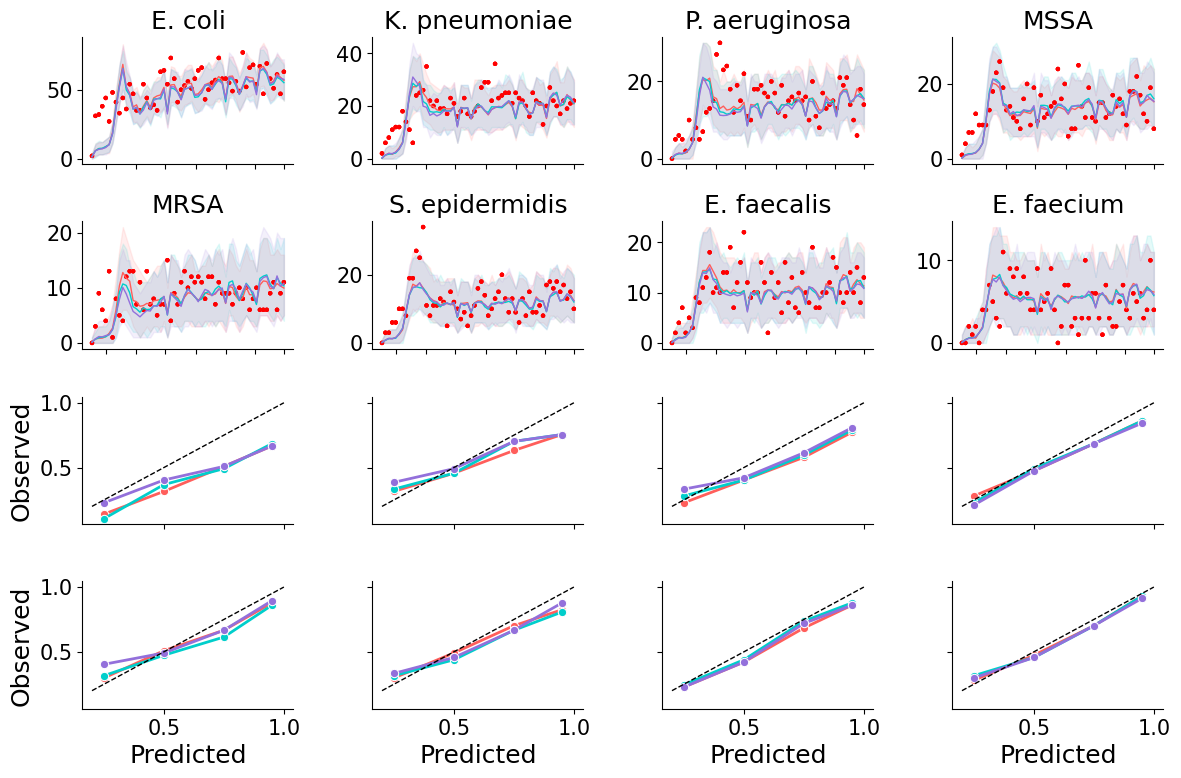

In [10]:
import seaborn as sns

COLORS_GAMMA = ["#ff5e5b", "#00cecb", "mediumpurple"]

#fig, axes = plt.subplots(2, 4, figsize=(15.2, 7.5), sharex=True, sharey=False)

fig     = plt.figure(constrained_layout=True, figsize=(12.5, 7.2))
subfigs = fig.subfigures(2, 1, hspace=0.05, wspace=0.05, height_ratios=[0.5, 0.5])

axes   = subfigs[0].subplots(2, 4, sharex="col")
axes_c = subfigs[1].subplots(2, 4, sharex=True, sharey=True)

for idx_amro, amro in enumerate(amro_search):
    gammas       = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
    obs_df       = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")

    hosp_calibration_df = pd.DataFrame()
    for idx_gamma, gamma in enumerate(gammas):
        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
        sim_post        = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"))
        sim_df          = create_sim_df(sim_post["y"].transpose(1, 2, 0), model_settings)

        hosp_df      = sim_df.groupby(["date", "ens_id"]).sum()[["value"]].reset_index()
        hosp_samples = hosp_df.pivot(index="date", columns="ens_id", values="value").to_numpy()
        hosp_samples = np.expand_dims(hosp_samples, 0)

        c_df                = calibration(hosp_samples, np.expand_dims(obs_df[[f"y{i+1}" for i in range(model_settings["k"])]].sum(axis=1).to_numpy(), 0))
        c_df["observation"] = "agg"
        c_df["amro"]        = amro
        c_df["gamma"]       = gamma

        hosp_calibration_df = pd.concat([hosp_calibration_df, c_df])
        hosp_df = create_df_response(np.squeeze(hosp_samples), time   = len(if_settings["assimilation_dates"]),
                                                                dates = if_settings["assimilation_dates"])
        axi     = axes.flatten()[idx_amro]

        axi.plot(if_settings["assimilation_dates"], hosp_df["mean"], color=COLORS_GAMMA[idx_gamma], lw=1.0, label=r"$\gamma$_{}".format(idx_gamma))
        axi.fill_between(if_settings["assimilation_dates"], hosp_df["low_95"], hosp_df["high_95"], color=COLORS_GAMMA[idx_gamma], alpha=0.1)
        #axi.fill_between(if_settings["assimilation_dates"], hosp_df["low_50"], hosp_df["high_50"], color=COLORS_GAMMA[idx_gamma], alpha=0.2)
        axi.scatter(if_settings["assimilation_dates"], obs_df[[f"y{i+1}" for i in range(model_settings["k"])]].sum(axis=1),
                                    ec=None, fc="r", label="Data", s=10)

        axi.set_title(amro2title(amro), fontsize=18)
        axi.tick_params(which='both', axis='x', labelrotation=75)
        axi.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.legend().remove()
        axi.set_ylabel(None)
        axi.set_xlabel(None)

    ax_c = axes_c.flatten()[idx_amro]
    sns.lineplot(ax     = ax_c,
                data    = hosp_calibration_df,
                x       = "quantiles",
                y       = "proportion_inside",
                marker  = "o",
                hue     = "gamma",
                palette = COLORS_GAMMA,
                lw      = 2)
    iden = np.arange(0.2, 1.1, 0.1)
    ax_c.plot(iden, iden, color="k", lw=1.0, ls="--")
    ax_c.spines['right'].set_visible(False)
    ax_c.spines['top'].set_visible(False)
    ax_c.legend().remove()
    ax_c.legend().remove()

axes_c[0, 0].set_ylabel("Observed")
axes_c[1, 0].set_ylabel("Observed")

for i in range(4):
    axes_c[1, i].set_xlabel("Predicted")

fig.suptitle("Calibration at hospital level.")
plt.tight_layout()

#fig.savefig(os.path.join(path_to_save_fig, "HospitalCalibration_gammaSens.png"), dpi=300, bbox_inches='tight', transparent=True)



# option 2

In [ ]:
pos2plot = {2:0, 4:1, 0:2, 3:3, 1:4, 5:5}


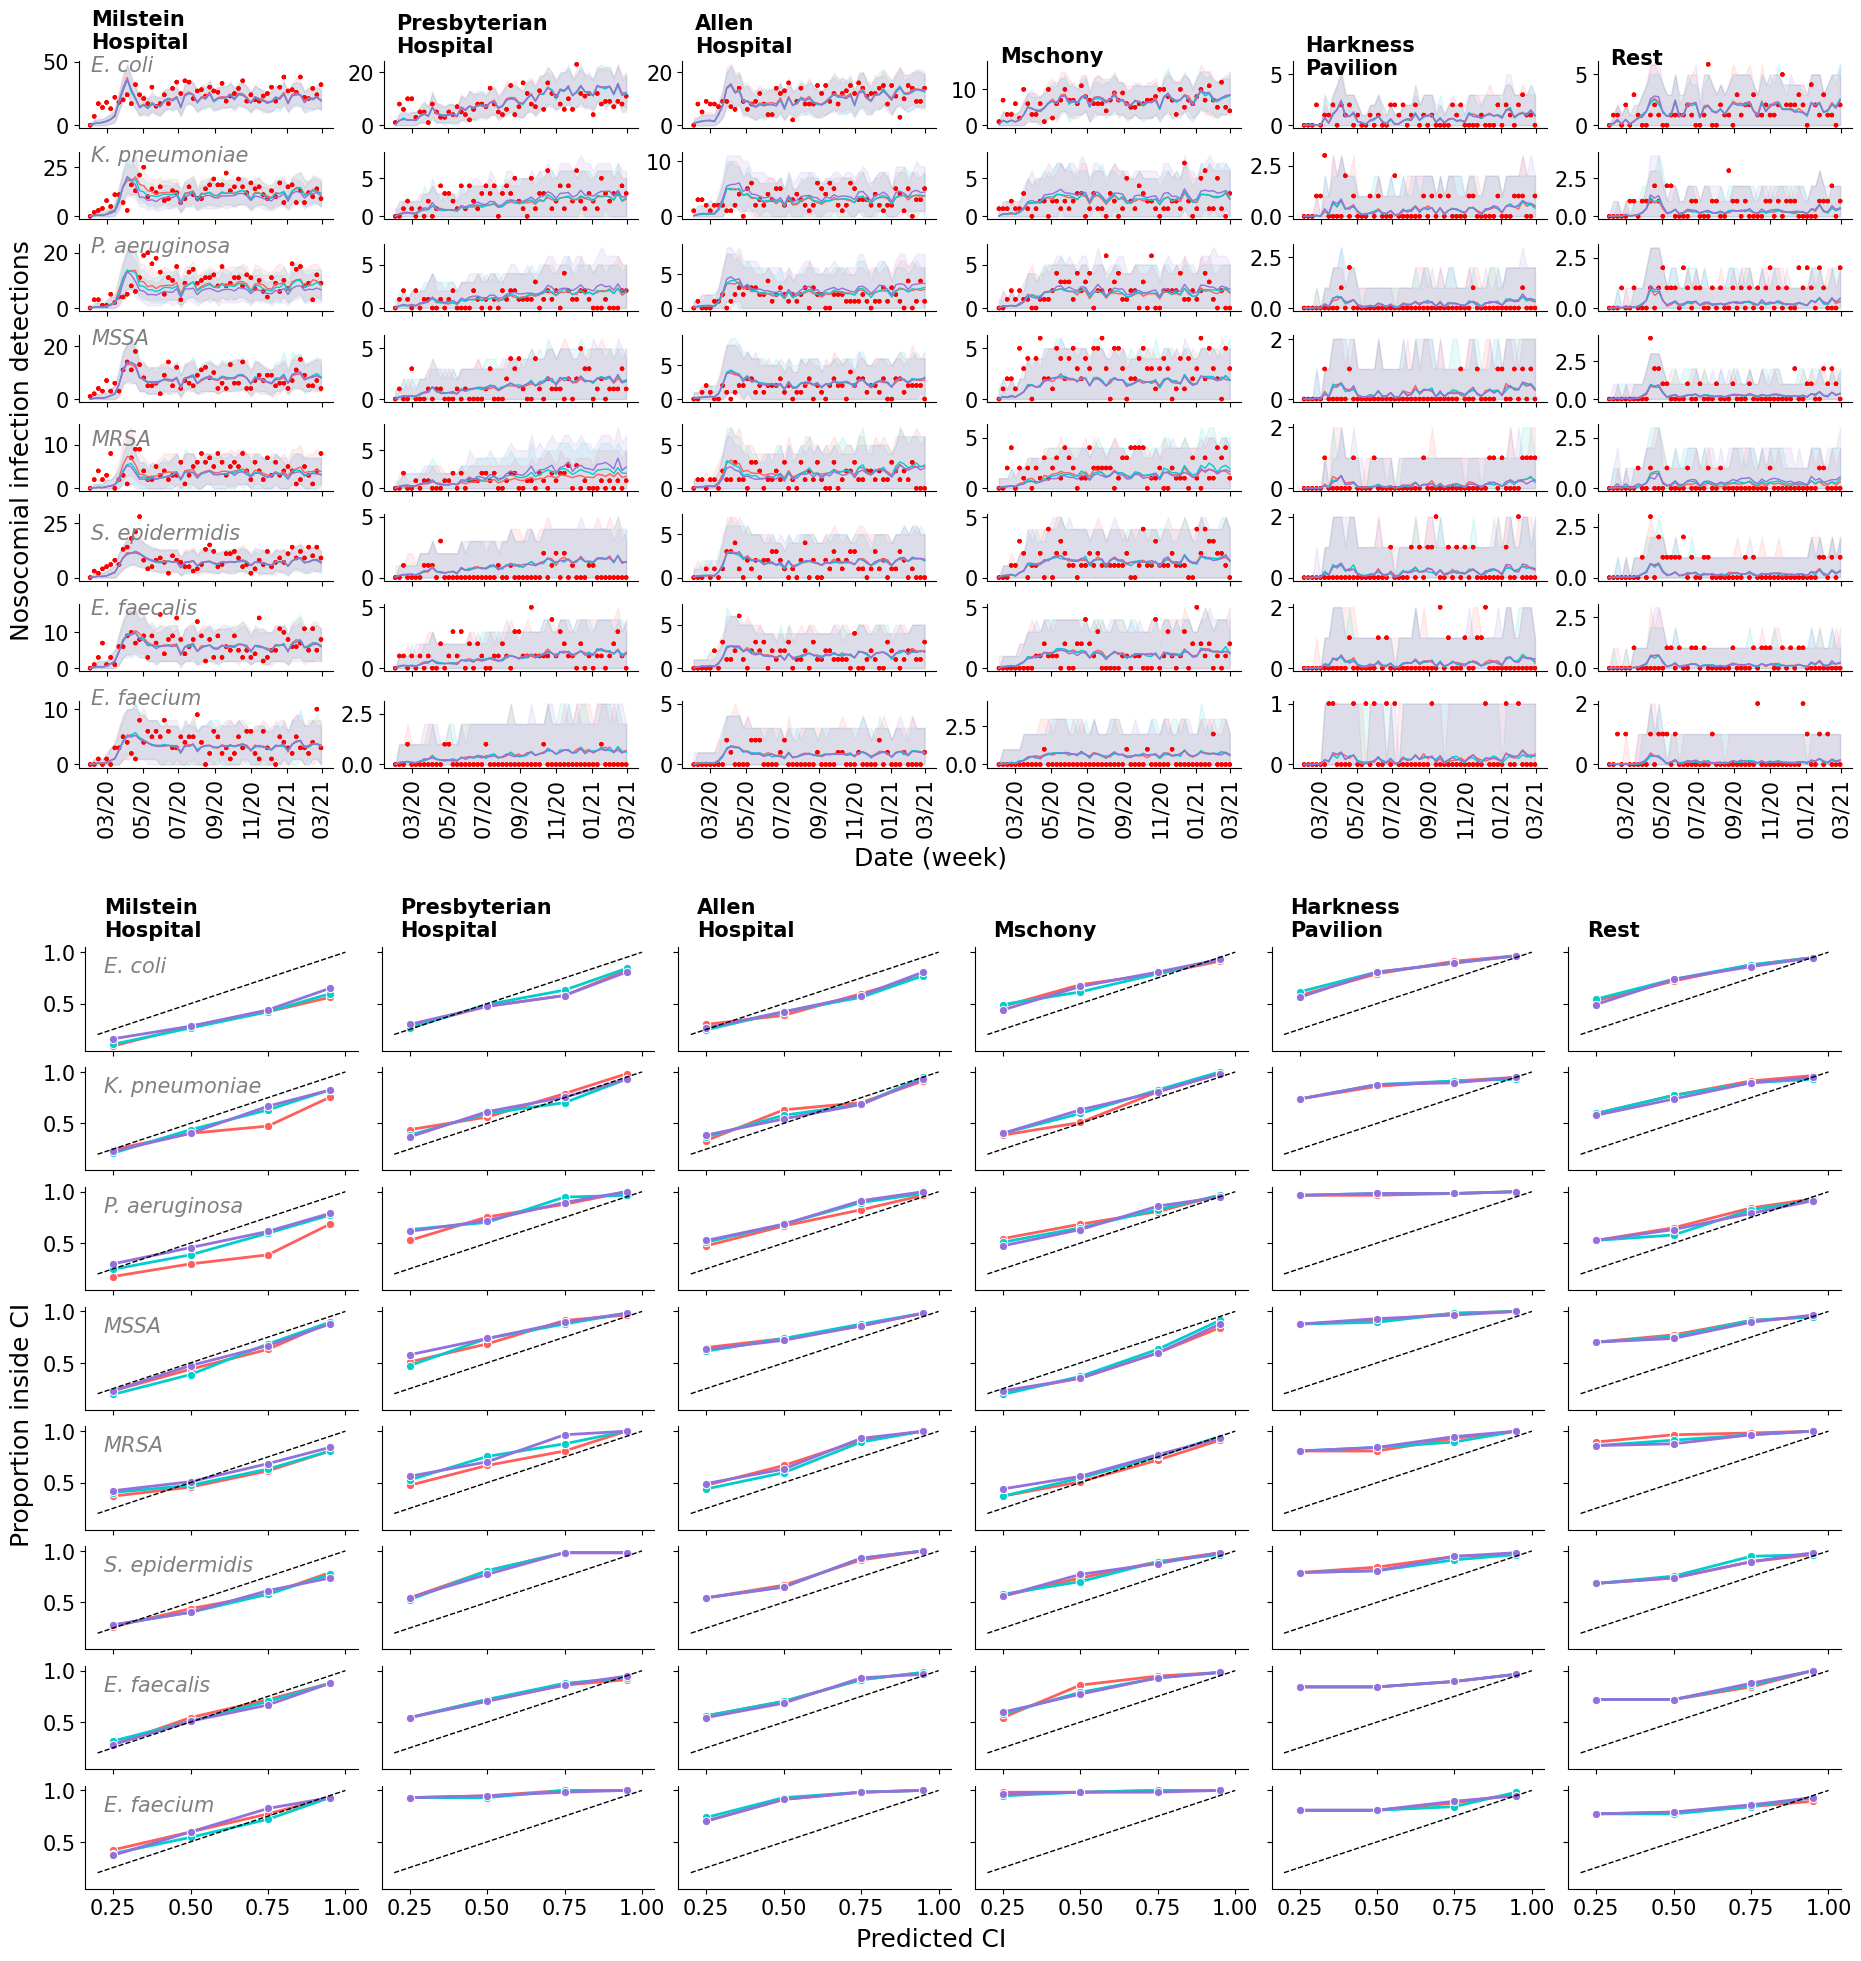

In [54]:
fig     = plt.figure(constrained_layout=True, figsize=(18.5, 19.5))
subfigs = fig.subfigures(2, 1, hspace=0.02, wspace=0.01, height_ratios=[0.45, 0.55])

axes     = subfigs[0].subplots(len(amro_search), model_settings["k"], sharex=True, sharey=False)
axes_cal = subfigs[1].subplots(len(amro_search), model_settings["k"], sharex=True, sharey=True)

for idx_amro, amro in enumerate(amro_search):
    gammas       = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
    obs_df       = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")

    #subfigs = fig.subfigures(2, 1, hspace=0.05, wspace=0.1, height_ratios=[0.45, 0.55])
    #fig = subfigs[idx_amro]
    #ax  = fig.subplots(2, 6, sharex=False, sharey=False)

    for ki in range(model_settings["k"]):
        hosp_calibration_df = pd.DataFrame()
        for idx_gamma, gamma in enumerate(gammas):

            path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
            sim_post        = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"))
            sim_df          = create_sim_df(sim_post["y"].transpose(1, 2, 0), model_settings)

            build_df      = sim_df[sim_df.yi == ki]
            build_samples = build_df.pivot(index="date", columns="ens_id", values=f"value").to_numpy()
            build_samples = np.expand_dims(build_samples, 0)

            c_df                = calibration(build_samples, obs_df[[f"y{ki+1}"]].to_numpy().T)
            c_df["observation"] = f"y{ki+1}"
            c_df["amro"]        = amro
            c_df["gamma"]       = gamma
            c_df["k"]           = ki
            hosp_calibration_df = pd.concat([hosp_calibration_df, c_df])

            build_df = create_df_response(np.squeeze(build_samples), time = len(if_settings["assimilation_dates"]),
                                                                    dates = if_settings["assimilation_dates"])

            axes[idx_amro, pos2plot[ki]].plot(if_settings["assimilation_dates"], build_df["mean"], color=COLORS_GAMMA[idx_gamma], lw=1.0, label=r"$\gamma$_{}".format(idx_gamma))
            axes[idx_amro, pos2plot[ki]].fill_between(if_settings["assimilation_dates"], build_df["low_95"], build_df["high_95"], color=COLORS_GAMMA[idx_gamma], alpha=0.1)
            axes[idx_amro, pos2plot[ki]].scatter(if_settings["assimilation_dates"], obs_df[[f"y{ki+1}"]], ec=None, fc="r", label="Data", s=10)

        if idx_amro==0:
            axes[0, pos2plot[ki]].text(x = 18296.0, y = build_df["high_95"].max()+build_df["low_95"].mean()*1.1,
                                    s="\n".join(id2building[ki].split("-")[0].split(" ")), fontweight = "bold")

            axes_cal[0, pos2plot[ki]].text(x = 0.22, y = 1.15,
                                                s="\n".join(id2building[ki].split("-")[0].split(" ")), fontweight = "bold")

        if pos2plot[ki]==0:
            axes[idx_amro, 0].text(x = 18296.0, y = build_df["high_95"].max() - build_df["low_95"].mean()*0.5,
                                    s=amro2title(amro), style="italic", color="gray")

            axes_cal[idx_amro, 0].text(x = 0.22, y = 0.8,
                                                s=amro2title(amro), style="italic", color="gray")

        axes[idx_amro, pos2plot[ki]].tick_params(which='both', axis='x', labelrotation=90)
        axes[idx_amro, pos2plot[ki]].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
        axes[idx_amro, pos2plot[ki]].spines['right'].set_visible(False)
        axes[idx_amro, pos2plot[ki]].spines['top'].set_visible(False)
        axes[idx_amro, pos2plot[ki]].legend().remove()
        axes[idx_amro, pos2plot[ki]].set_ylabel(None)
        axes[idx_amro, pos2plot[ki]].set_xlabel(None)

        sns.lineplot(ax     = axes_cal[idx_amro, pos2plot[ki]],
                    data    = hosp_calibration_df,
                    x       = "quantiles",
                    y       = "proportion_inside",
                    marker  = "o",
                    hue     = "gamma",
                    palette = COLORS_GAMMA,
                    lw      = 2)

        iden = np.arange(0.2, 1.1, 0.1)
        axes_cal[idx_amro, pos2plot[ki]].plot(iden, iden, color="k", lw=1.0, ls="--")
        axes_cal[idx_amro, pos2plot[ki]].spines['right'].set_visible(False)
        axes_cal[idx_amro, pos2plot[ki]].spines['top'].set_visible(False)
        axes_cal[idx_amro, pos2plot[ki]].legend().remove()
        axes_cal[idx_amro, pos2plot[ki]].set_ylabel(None)
        axes_cal[idx_amro, pos2plot[ki]].set_xlabel(None)

subfigs[0].supylabel("Nosocomial infection detections")
subfigs[0].supxlabel("Date (week)")

subfigs[1].supylabel("Proportion inside CI")
subfigs[1].supxlabel("Predicted CI")

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures", "BuildingAMROsimulations_figS11.png"),
                                                                dpi=300, transparent=True, bbox_inches = 'tight')



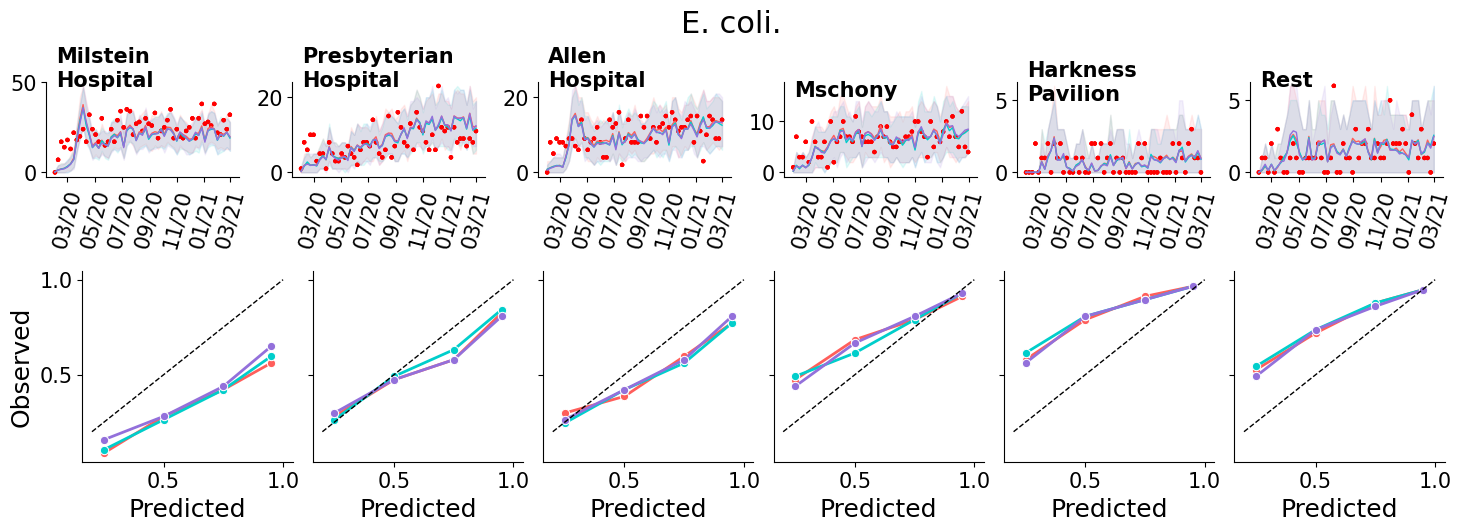

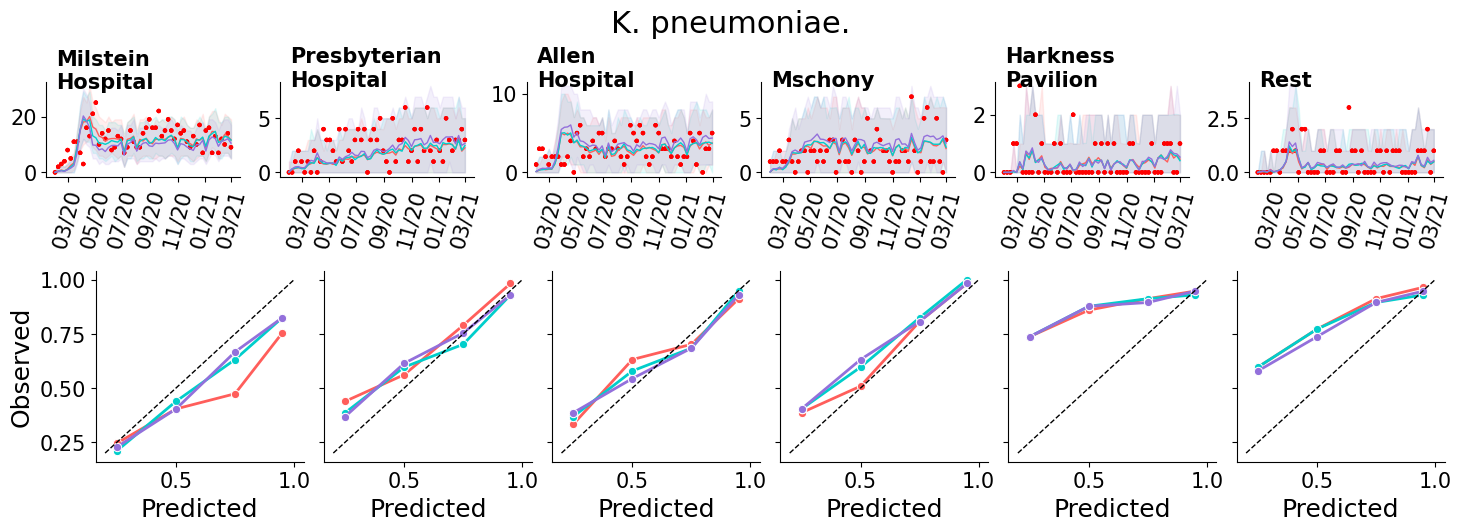

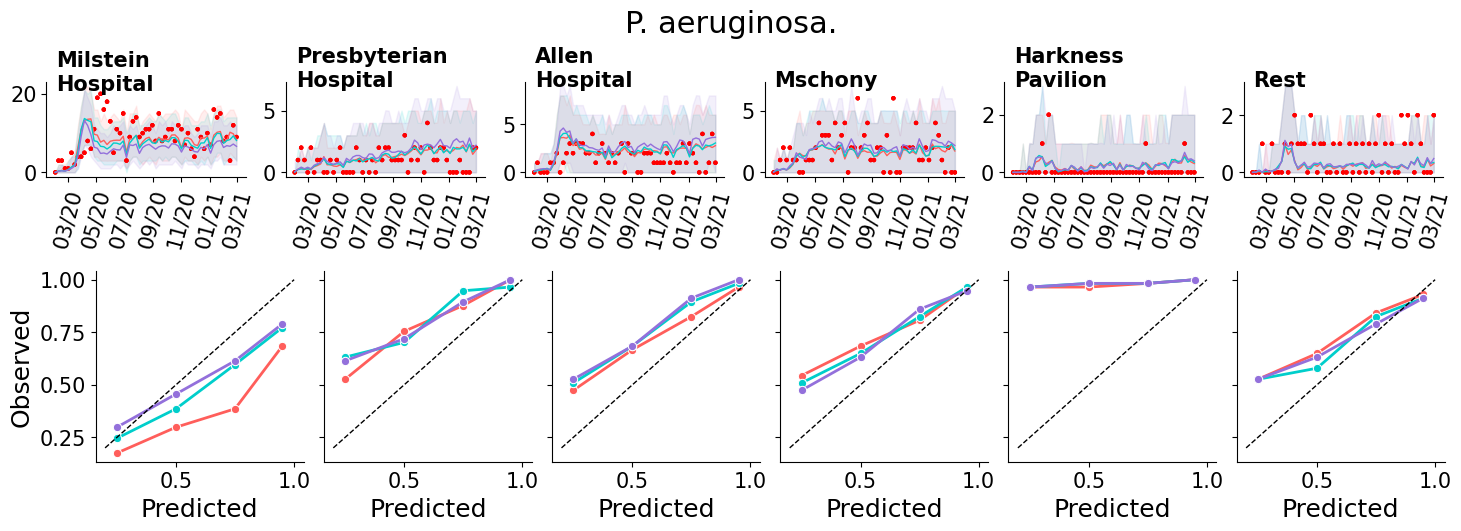

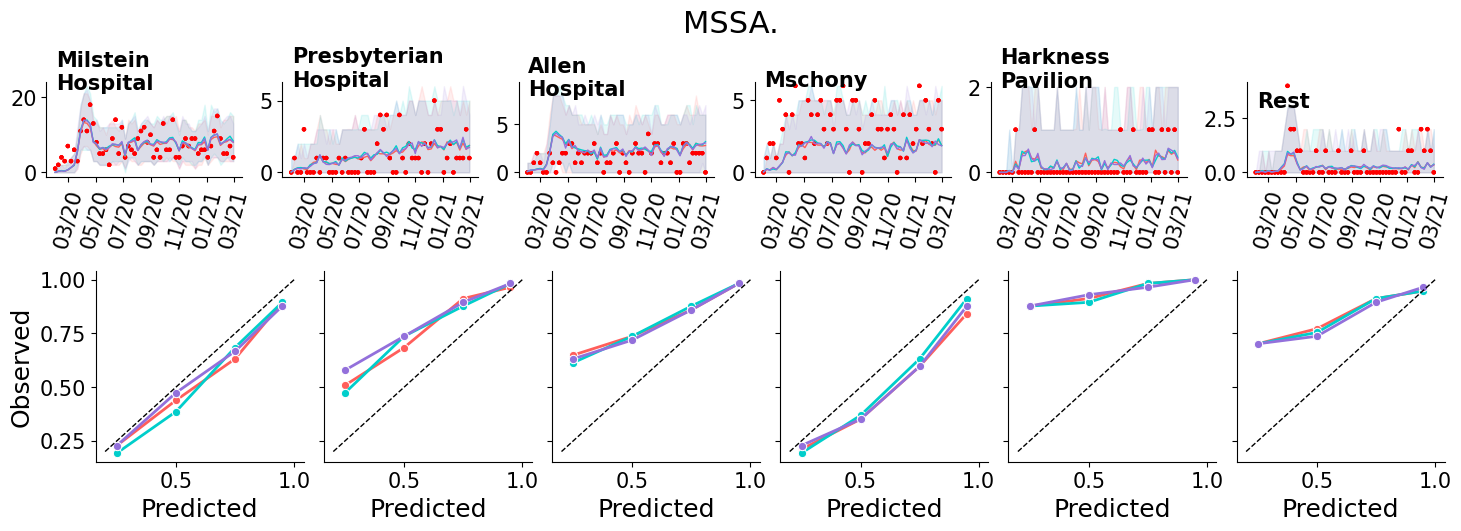

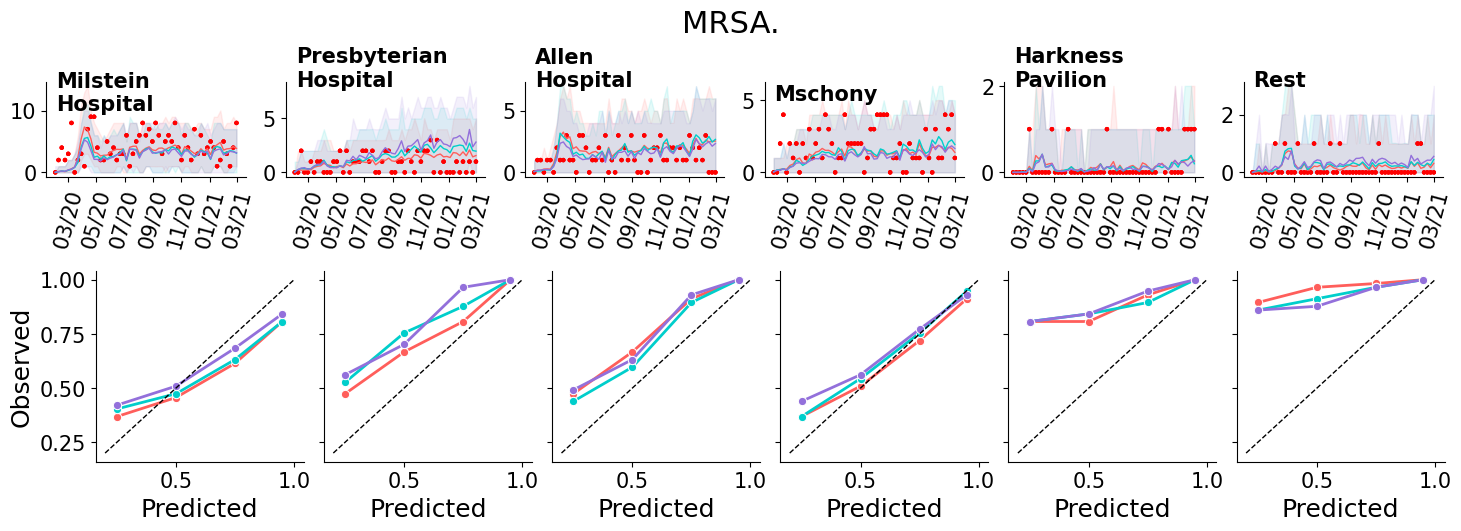

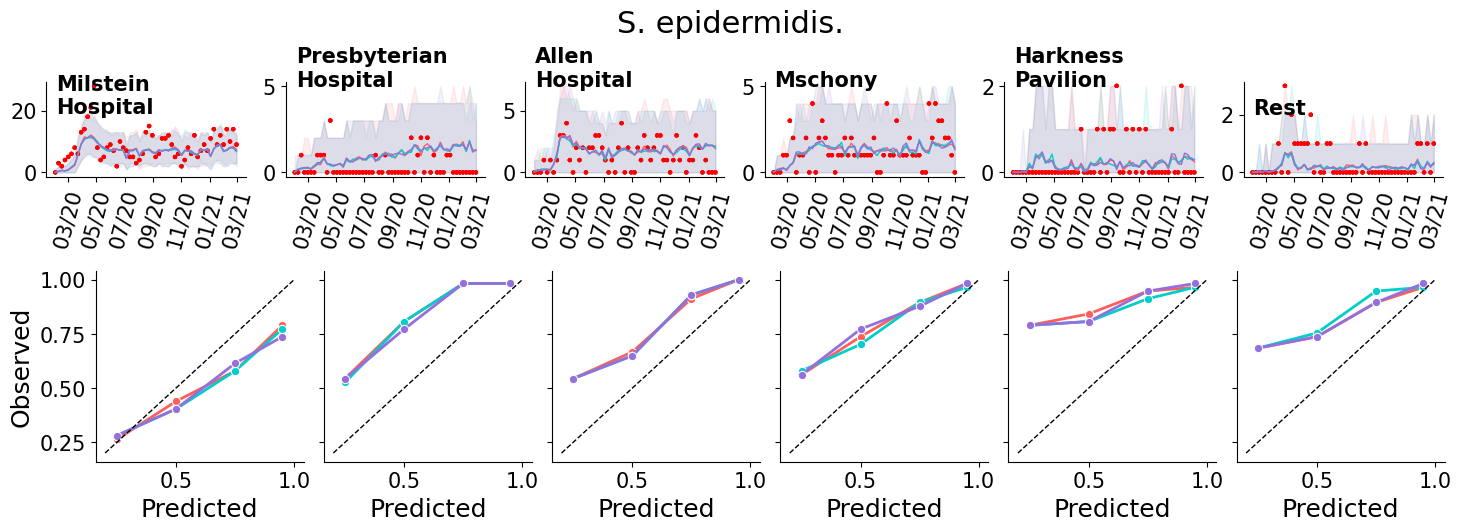

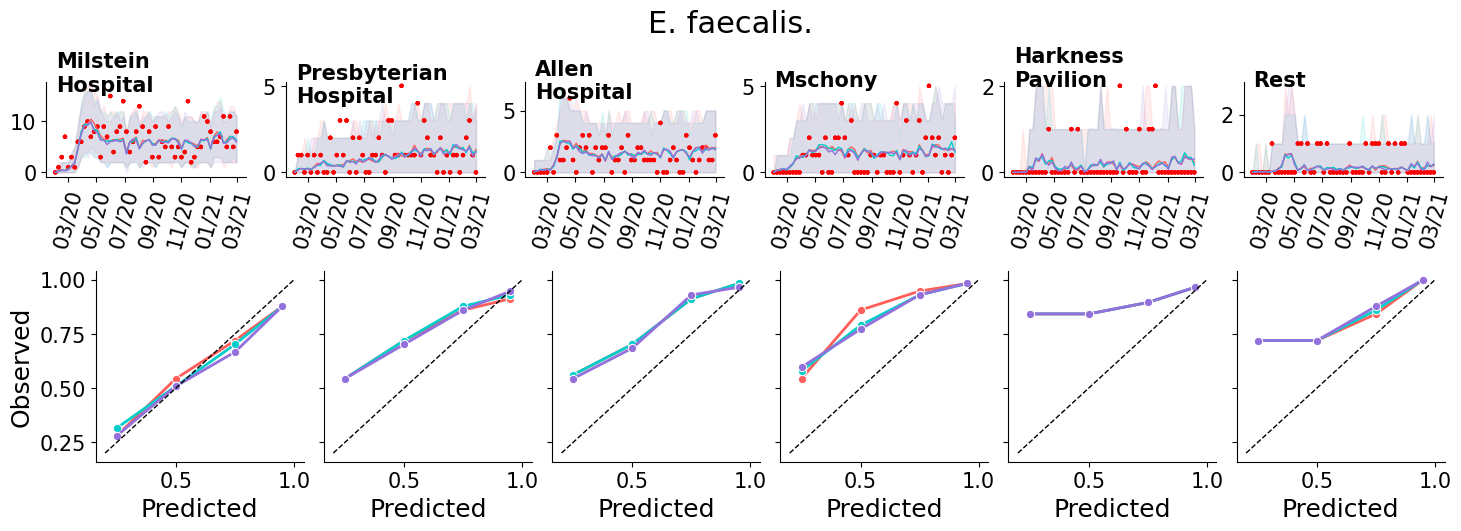

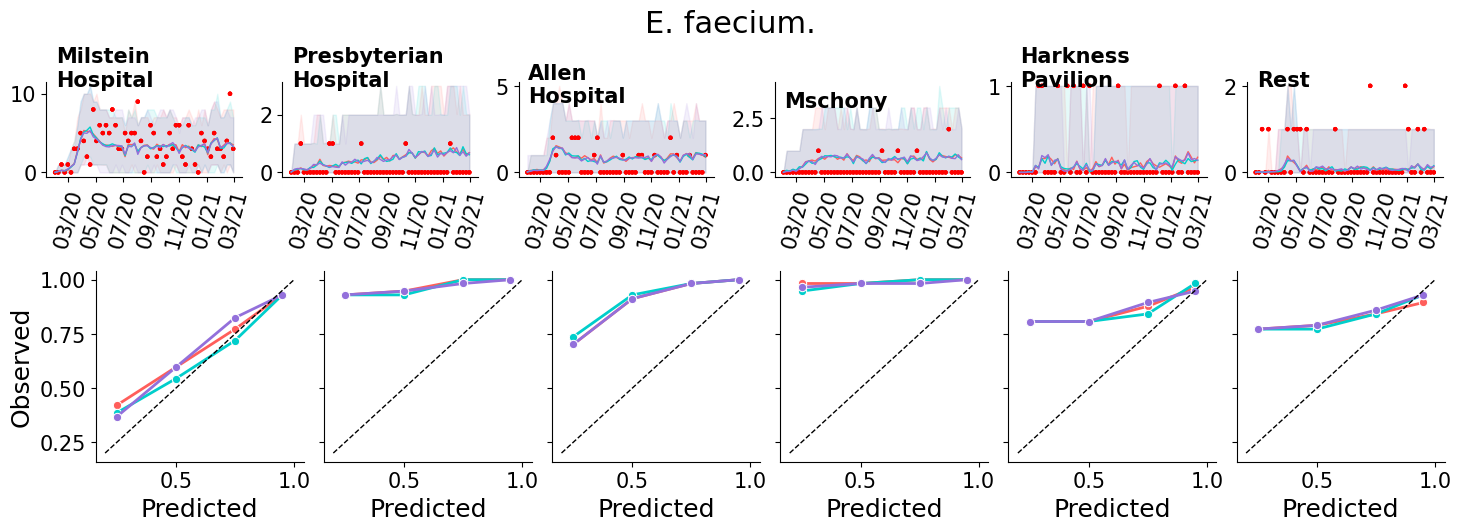

In [12]:
pos2plot = {2:0, 4:1, 0:2, 3:3, 1:4, 5:5}

for amro in amro_search:
    gammas       = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
    obs_df       = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")

    fig      = plt.figure(constrained_layout=True, figsize=(14.5, 5.2))
    subfigs  = fig.subfigures(2, 1, hspace=0.05, wspace=0.1, height_ratios=[0.45, 0.55])

    axes_1   = subfigs[0].subplots(1, model_settings["k"], sharex=True, sharey=False)
    axes_2   = subfigs[1].subplots(1, model_settings["k"], sharex=True, sharey=True)

    for ki in range(model_settings["k"]):
        hosp_calibration_df = pd.DataFrame()
        for idx_gamma, gamma in enumerate(gammas):
            path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}")
            sim_post        = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"))
            sim_df          = create_sim_df(sim_post["y"].transpose(1, 2, 0), model_settings)

            build_df      = sim_df[sim_df.yi == ki]
            build_samples = build_df.pivot(index="date", columns="ens_id", values=f"value").to_numpy()
            build_samples = np.expand_dims(build_samples, 0)

            c_df                = calibration(build_samples, obs_df[[f"y{ki+1}"]].to_numpy().T)
            c_df["observation"] = f"y{ki+1}"
            c_df["amro"]        = amro
            c_df["gamma"]       = gamma
            c_df["k"]           = ki
            hosp_calibration_df = pd.concat([hosp_calibration_df, c_df])

            build_df = create_df_response(np.squeeze(build_samples), time = len(if_settings["assimilation_dates"]),
                                                                    dates = if_settings["assimilation_dates"])

            axi = axes_1[pos2plot[ki]]
            axi.plot(if_settings["assimilation_dates"], build_df["mean"], color=COLORS_GAMMA[idx_gamma], lw=1.0, label=r"$\gamma$_{}".format(idx_gamma))
            axi.fill_between(if_settings["assimilation_dates"], build_df["low_95"], build_df["high_95"], color=COLORS_GAMMA[idx_gamma], alpha=0.1)
            axi.scatter(if_settings["assimilation_dates"], obs_df[[f"y{ki+1}"]], ec=None, fc="r", label="Data", s=10)

        axi.text(x = 18296.0, y = build_df["high_95"].max(),
                    s="\n".join(id2building[ki].split("-")[0].split(" ")), fontweight = "bold")

        axi.tick_params(which='both', axis='x', labelrotation=75)
        axi.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.legend().remove()
        axi.set_ylabel(None)
        axi.set_xlabel(None)

        sns.lineplot(ax     = axes_2[pos2plot[ki]],
                    data    = hosp_calibration_df,
                    x       = "quantiles",
                    y       = "proportion_inside",
                    marker  = "o",
                    hue     = "gamma",
                    palette = COLORS_GAMMA,
                    lw      = 2)

        iden = np.arange(0.2, 1.1, 0.1)
        axes_2[pos2plot[ki]].plot(iden, iden, color="k", lw=1.0, ls="--")
        axes_2[pos2plot[ki]].spines['right'].set_visible(False)
        axes_2[pos2plot[ki]].spines['top'].set_visible(False)
        axes_2[pos2plot[ki]].legend().remove()
        axes_2[pos2plot[ki]].set_ylabel(None)

    axes_2[0].set_ylabel("Observed")
    for i in range(model_settings["k"]):
        axes_2[i].set_xlabel("Predicted")

    fig.suptitle(f"{amro2title(amro)}.")


    fig.savefig(os.path.join(path_to_save_fig, f"BuildingCalibration_gammaSens{amro2cute(amro)}.png"), dpi=300, bbox_inches='tight', transparent=True)
